In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)

In [43]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

In [44]:
df = pd.read_csv('../../data/dataset.csv')

In [45]:
df.head()

,Player_id,Season,Games,PPG,Goals,Assists,Yellow_cards,Yellow_red_cards,Red_cards,Penalty_goals,Minutes_per_goal,Minutes_played,Club_id,Competition,MarketValue,name,age,Days_injured,international,Liga,Liga_level,W,D,L,Points,Goales_scored,Goales_conceded
0,10,2004,45,1.60,17,11,4,0,0,0,110.0,3244,86,Bundesliga,12000000,Miroslav Klose,26.0,0.0,1,Bundesliga,First Tier,18,5,11,59,68,37
1,690,2004,41,1.80,19,14,5,0,0,0,136.0,3001,86,Bundesliga,7500000,Ivan Klasnic,24.0,0.0,1,Bundesliga,First Tier,18,5,11,59,68,37
2,4316,2004,35,1.74,1,0,2,0,0,0,478.0,2985,86,Bundesliga,4500000,Petri Pasanen,24.0,0.0,1,Bundesliga,First Tier,18,5,11,59,68,37
3,4403,2004,28,1.82,3,6,4,0,0,0,130.0,1898,86,Bundesliga,4000000,Daniel Jensen,25.0,0.0,1,Bundesliga,First Tier,18,5,11,59,68,37
4,10,2005,40,1.70,31,17,5,1,0,1,115.0,3313,86,Bundesliga,30000000,Miroslav Klose,27.0,0.0,1,Bundesliga,First Tier,21,7,6,70,79,37


/var/folders/xs/q9dzr7kj4_n9r_lt2bnclblr0000gn/T/ipykernel_15894/3039969478.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(df['MarketValue']+2))


<Axes: xlabel='MarketValue', ylabel='Density'>

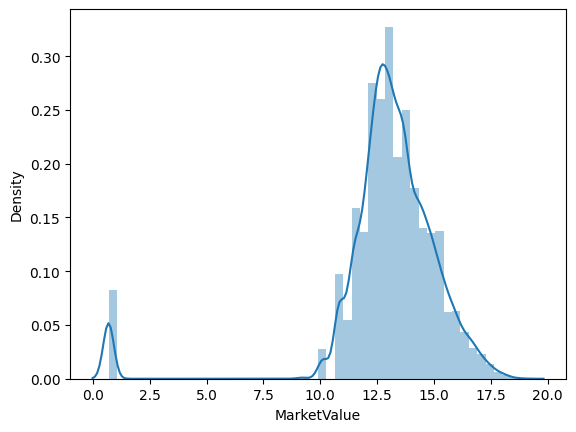

In [46]:
# plot the distribution of MarketValue
sns.distplot(np.log(df['MarketValue']+2))

In [47]:
# define categorical features
categorical_features = ['Club_id', 'Competition', 'Liga_level']
df[categorical_features] = df[categorical_features].astype('category')

# and drop the name column (becasue it cant handle strings that are not categorical)
df = df.drop(columns=['name', 'Liga', 'Yellow_cards', 'Red_cards', 'Yellow_red_cards', 'Penalty_goals'])

In [48]:
# split data into train and test, train is every season before 2022
train = df[df['Season'] < 2022]
test = df[df['Season'] == 2022]

x_train = train.drop(['MarketValue'], axis=1)
y_train = train['MarketValue']
x_test = test.drop(['MarketValue'], axis=1)
y_test = test['MarketValue']
y_train = np.log10(y_train + 1)

In [49]:
model = CatBoostRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    thread_count=-1,
    max_depth=6,
    silent=True,
    loss_function='RMSE',
    random_seed=42,
    bagging_temperature=0.3,
    od_type="Iter"
)

In [50]:
model.fit(x_train, y_train, cat_features=categorical_features)

Text(0.5, 1.0, 'Feature Importance')

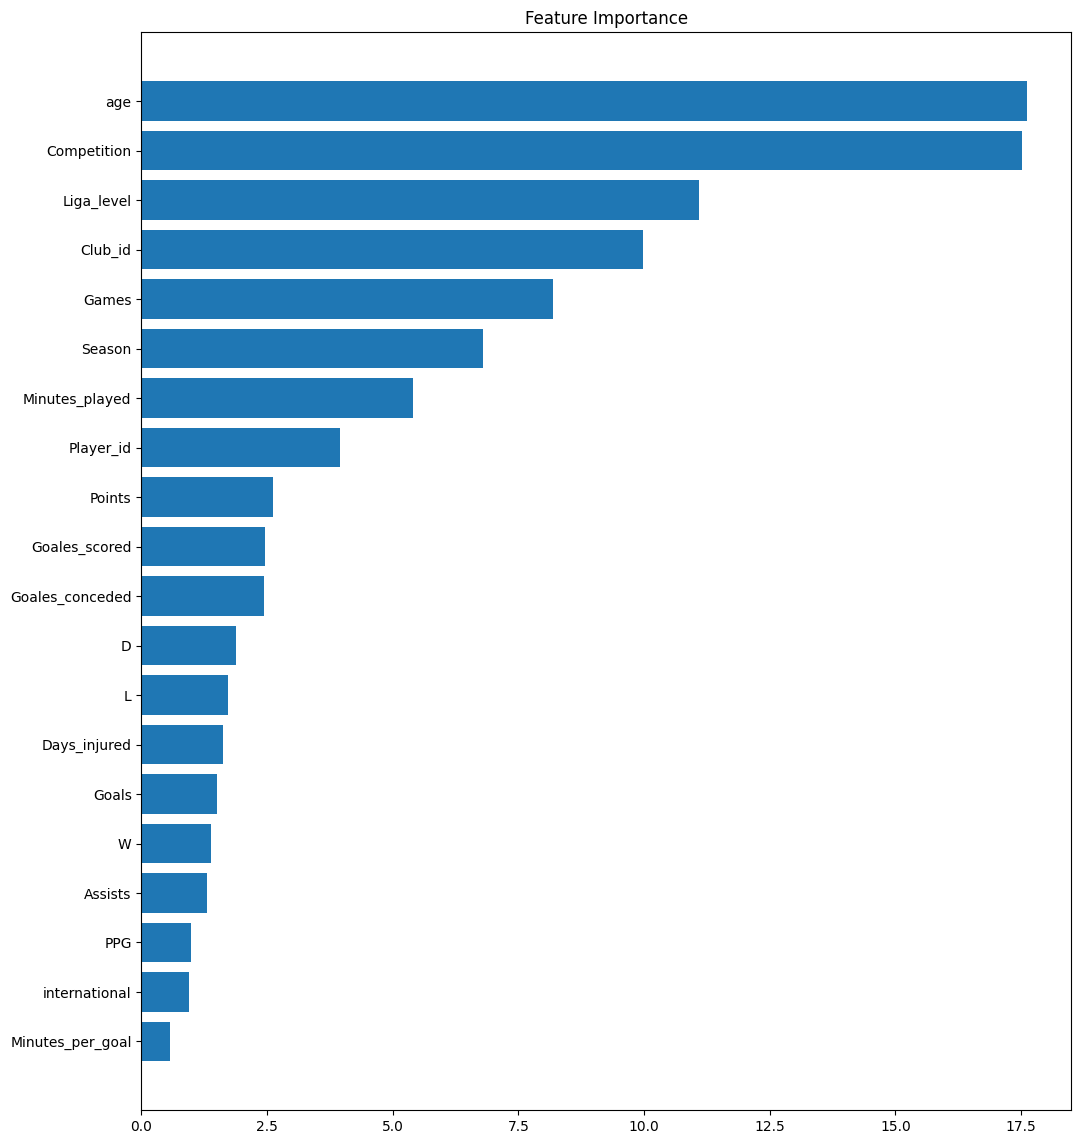

In [51]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 14))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.drop(['MarketValue'], axis = 1).columns)[sorted_idx])
plt.title('Feature Importance')

In [52]:
pred = model.predict(x_test)
pred = 10**(pred) - 1
pred[pred < 0] = pred.mean()
cat_rmsle = round(rmsle(y_test, pred), 2)
print('Test RMSLE:', cat_rmsle)

Test RMSLE: 2.26
